In [1]:
# --- Set cores and seed ---
import os
N_CORES = 4
os.environ["XLA_FLAGS"] = f"--xla_force_host_platform_device_count={N_CORES}"

import numpy as np
import jax.numpy as jnp
import jax
from jax import random
import matplotlib.pyplot as plt
import matplotlib
matplotlib.rcParams['figure.facecolor'] = 'white'
matplotlib.rcParams['savefig.facecolor'] = 'white'

import networkx as nx

import numpyro
from numpyro.infer import SVI, Trace_ELBO, Predictive, MCMC, NUTS
from numpyro.optim import ClippedAdam
from numpyro.infer.autoguide import AutoMultivariateNormal, AutoLowRankMultivariateNormal, AutoNormal
import numpyro.distributions as dist

import src.utils as utils

import Data.cs_aarhus.util_data as ud



In [2]:
network_data = ud.network_data()

print(network_data.keys())
print(network_data["adj_mat_dict"].keys(), network_data["adj_mat_dict"]['facebook'].shape)

dict_keys(['adj_mat_dict', 'triu_dict'])
dict_keys(['lunch', 'facebook', 'leisure', 'work']) (61, 61)


In [3]:
layers = list(network_data["adj_mat_dict"].keys())

for layer in layers:
    print("-" * 40)
    print(f"Layer : {layer}")
    print("n_edge:", network_data["adj_mat_dict"][layer].sum()/2)
    deg = network_data["adj_mat_dict"][layer].sum(axis=1)
    avg_deg = deg[deg > 0].mean()
    print("avg_deg (>0):", avg_deg)
    print("ave_deg:", network_data["adj_mat_dict"][layer].sum(axis=1).mean())
    print("-" * 40)


----------------------------------------
Layer : lunch
n_edge: 193.0
avg_deg (>0): 6.433334
ave_deg: 6.3278685
----------------------------------------
----------------------------------------
Layer : facebook
n_edge: 124.0
avg_deg (>0): 7.75
ave_deg: 4.0655737
----------------------------------------
----------------------------------------
Layer : leisure
n_edge: 88.0
avg_deg (>0): 3.7446806
ave_deg: 2.8852458
----------------------------------------
----------------------------------------
Layer : work
n_edge: 194.0
avg_deg (>0): 6.466667
ave_deg: 6.3606553
----------------------------------------


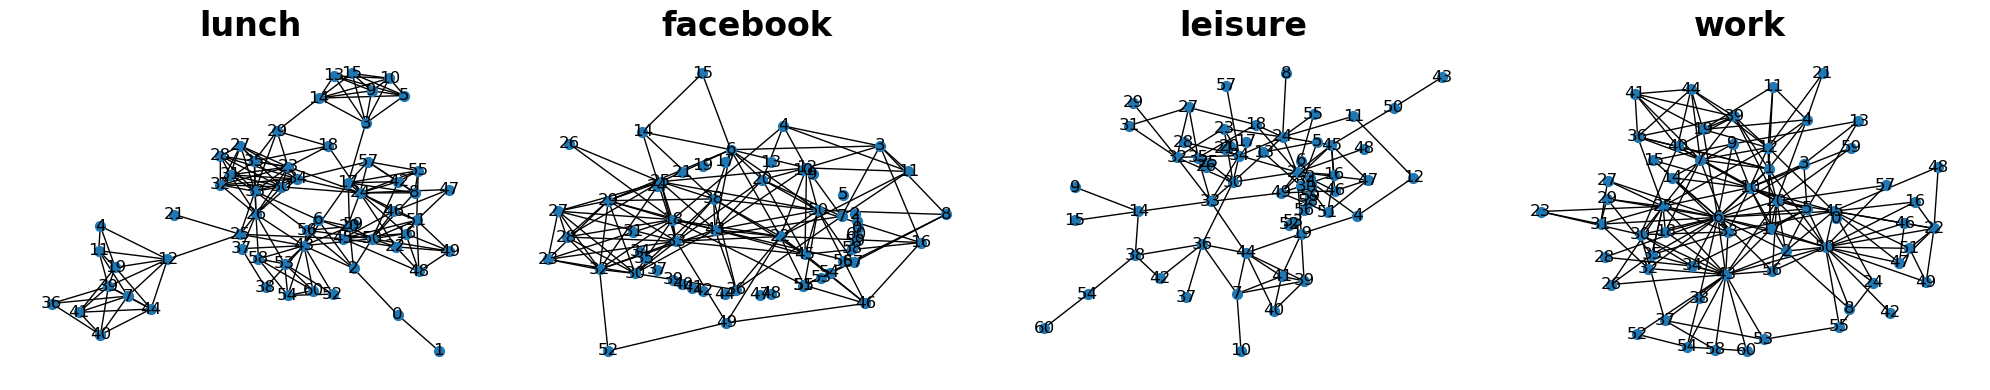

In [4]:

fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(20, 4))
for i in range(4):
# for layer in networks_dict.keys():
    G = nx.from_numpy_array(np.array(network_data["adj_mat_dict"][layers[i]]))
    # pos = nx.circular_layout(G)
    pos = nx.kamada_kawai_layout(G)
    # pos = nx.random_layout(G, seed=42)
    nx.draw_networkx(
        G,
        pos=pos,
        ax=axes[i],
        node_size=50,
        with_labels=True
    )
    axes[i].set_title(f"{layers[i]}", fontsize=24, color='black', fontweight='bold')
    axes[i].axis('off')
plt.tight_layout()
plt.show()

In [13]:
obs_triu, latent_triu = ud.triu_array_obs_n_latent(network_data["triu_dict"],"lunch")

print(obs_triu.shape, latent_triu.shape)


(3, 1830) (1830,)


In [9]:
# obs_layers_triu = four_layers_triu[:3]
# latent_layer_triu = four_layers_triu[3]

# obs_layers_triu = four_layers_triu[1:]
# latent_layer_triu = four_layers_triu[0]

# obs_layers_triu = four_layers_triu[jnp.array([0, 1, 3])]   
# latent_layer_triu = four_layers_triu[2]

obs_layers_triu = four_layers_triu[jnp.array([0, 2, 3])]   
latent_layer_triu = four_layers_triu[1]

print(obs_layers_triu.shape, latent_layer_triu.shape)
# latent_layer_triu = triu_values[2]

(3, 1830) (1830,)


In [10]:

rng_key, _ = random.split(random.PRNGKey(5))


# Run the model

kernel = NUTS(multi_model)
mcmc = MCMC(kernel, num_warmup=2000, num_samples=2500, num_chains=4)
mcmc.run(rng_key, triu_vals=obs_layers_triu)

mcmc.print_summary()

samples = mcmc.get_samples()
print(samples.keys())


  0%|          | 0/4500 [00:00<?, ?it/s]

  0%|          | 0/4500 [00:00<?, ?it/s]

  0%|          | 0/4500 [00:00<?, ?it/s]

  0%|          | 0/4500 [00:00<?, ?it/s]


                    mean       std    median      5.0%     95.0%     n_eff     r_hat
        V[0,0]      0.05      1.53      0.04     -2.14      2.34    225.82      1.03
        V[0,1]      0.12      1.50      0.25     -2.17      2.26    224.13      1.03
        V[1,0]     -0.01      1.03     -0.05     -1.58      1.62    242.66      1.03
        V[1,1]      0.04      1.02      0.08     -1.54      1.61    199.55      1.03
        V[2,0]      0.04      0.40      0.04     -0.61      0.67    267.78      1.01
        V[2,1]      0.05      0.39      0.06     -0.58      0.66    309.67      1.01
        V[3,0]      0.13      1.05      0.22     -1.48      1.61    222.88      1.01
        V[3,1]      0.21      1.05      0.39     -1.45      1.64    272.89      1.01
        V[4,0]     -0.17      1.26     -0.29     -1.89      1.77    239.87      1.02
        V[4,1]     -0.07      1.25     -0.16     -1.88      1.80    219.74      1.02
        V[5,0]      0.12      0.98      0.21     -1.43      1.48

In [13]:
samples["probs_latent"].shape

(10000, 1830)

In [11]:
from src.MWG_sampler import sample_posterior_triu_star

rng_key, _ = random.split(rng_key)
post_probs = samples["probs_latent"].mean(axis=0)
post_triu = sample_posterior_triu_star(rng_key, post_probs, 10000)

print(post_triu.shape)


(10000, 1830)


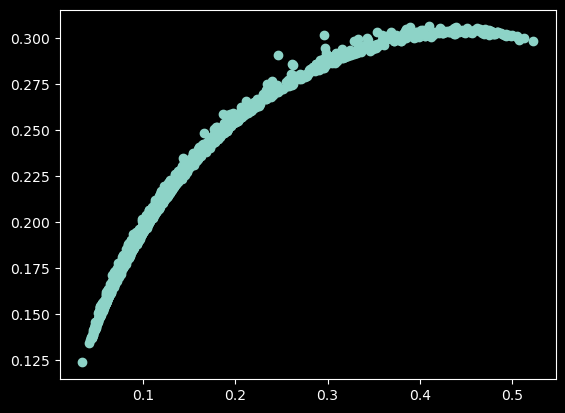

In [12]:
matplotlib.rcParams['figure.facecolor'] = 'black'
matplotlib.rcParams['savefig.facecolor'] = 'black'



plt.scatter(samples["probs_latent"].mean(axis=0), samples["probs_latent"].std(axis=0))


In [13]:
@jax.jit
def triu_to_mat(triu):
    mat = jnp.zeros((num_nodes, num_nodes))
    mat = mat.at[np.triu_indices(n=num_nodes, k=1)].set(triu)
    return mat + mat.T

@jax.jit
def compute_deg(triu):
    mat = triu_to_mat(triu)
    return jnp.sum(mat, axis=1)

vmap_deg = jax.vmap(compute_deg)



In [14]:
post_degs = vmap_deg(post_triu)
print(post_degs.shape)

print(post_degs.mean(axis=0), post_degs.std(axis=0))

(10000, 61)
[ 5.4596996  8.0947    10.6874     8.322      7.3546     8.580999
 11.090899   8.964499   9.2217     8.0604     8.9999     7.6885
  8.3263     7.7306     8.7258     7.8518996  8.9435    10.1241
  9.2102995  8.0433    10.7978     5.1445     9.2416    10.7858
 10.2862    10.5472    10.7225    10.087299  10.1952     9.1765995
 11.1733    10.378099  10.7737    11.2773    11.0167     9.9601
  8.907599   8.9081     8.669      8.5707     8.4032     8.2094
  9.251599  10.2116995  8.5133     9.597899   8.1747     7.4307
  7.1656     8.4713    10.5472     8.9375     6.2064     7.7216997
  7.0789     8.9766    10.8921995  9.469      7.7317     4.3268
  6.8664   ] [2.2061677 2.6007562 2.8877814 2.553217  2.4482358 2.5918021 2.9344568
 2.6082253 2.7231507 2.4999104 2.6392233 2.48919   2.5721252 2.4574018
 2.6145773 2.4912179 2.579323  2.8251548 2.6847856 2.4534516 2.919095
 2.1778474 2.6261053 2.820482  2.8253655 2.8975112 2.8808842 2.7471948
 2.768555  2.731705  2.8833778 2.7585394 2.8

0.43994018
6.9546413


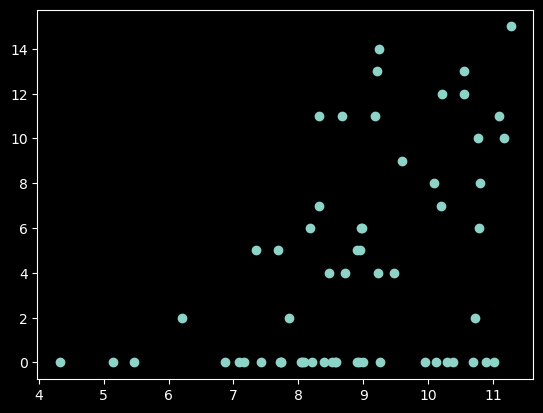

In [15]:


true_mat = triu_to_mat(latent_layer_triu)
true_deg = jnp.sum(true_mat, axis=1)

plt.scatter(post_degs.mean(axis=0), true_deg)

print(jnp.corrcoef(post_degs.mean(axis=0), true_deg)[0,1])
degs_rmse = jnp.sqrt(jnp.mean((post_degs - true_deg)**2))
print(degs_rmse)

In [16]:
import seaborn as sns

def plot_heatmaps(posterior_probs, true_values):
    """
    Plot two heatmaps side by side:
    - Left: Posterior mean probabilities of edges in the latent adjacency.
    - Right: True adjacency matrix of the latent layer.
    
    Arguments:
    - posterior_probs: n x n matrix of posterior mean probabilities (values in [0,1]).
    - true_values: n x n binary adjacency matrix (values in {0,1}).
    """
    fig, axes = plt.subplots(1, 2, figsize=(12, 5))
    
    # Heatmap of posterior mean probabilities
    sns.heatmap(posterior_probs, ax=axes[0], cmap="coolwarm", vmin=0, vmax=1, annot=False)
    axes[0].set_title("Posterior Mean Probabilities")
    
    # Heatmap of true adjacency matrix
    sns.heatmap(true_values, ax=axes[1], cmap="coolwarm", vmin=0, vmax=1, annot=False)
    axes[1].set_title("True Adjacency Matrix")
    
    plt.tight_layout()
    plt.show()

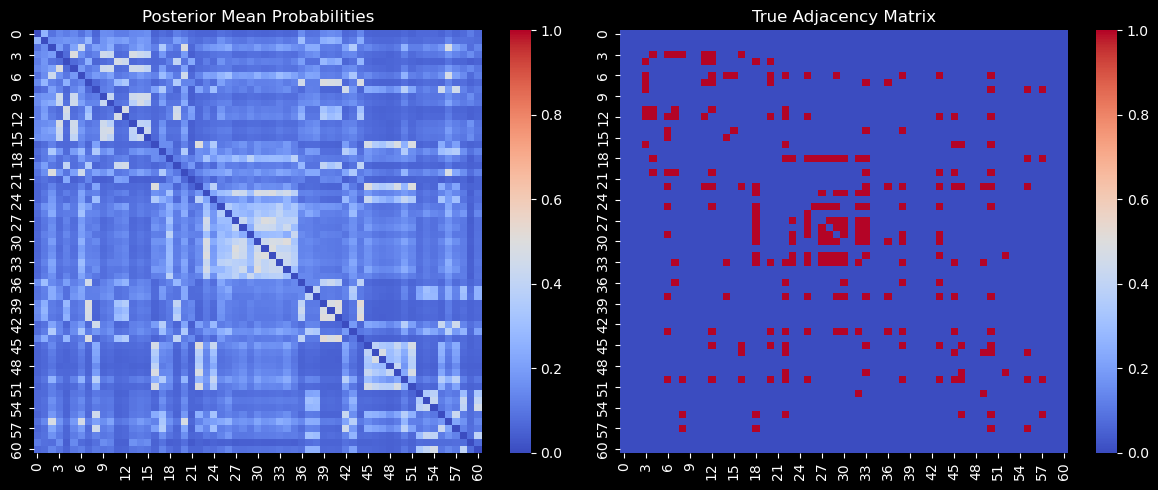

In [17]:
post_probs_mat = triu_to_mat(post_probs)
plot_heatmaps(post_probs_mat, true_mat)

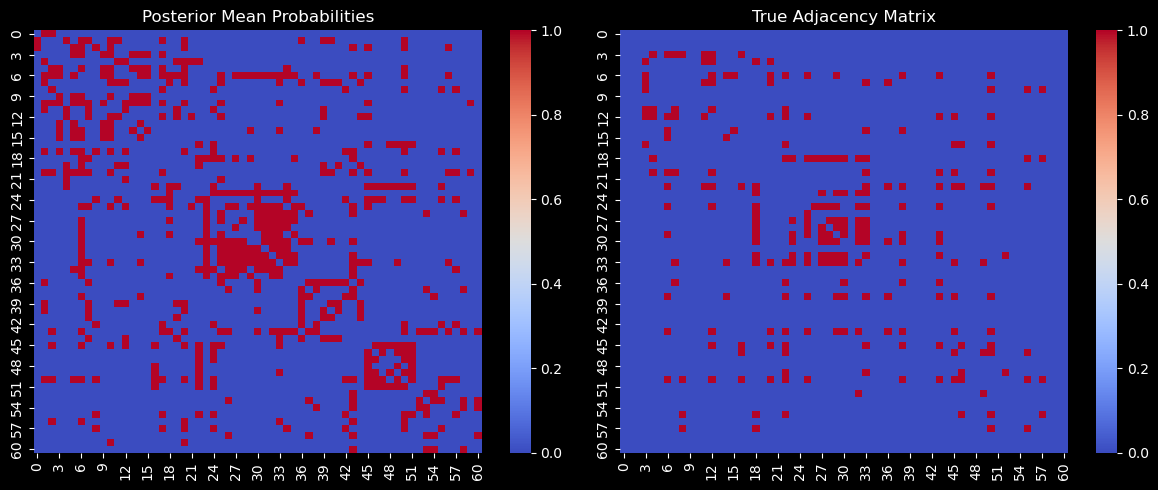

In [18]:
# aggreagted network by either 'OR' or 'AND' for all edges in observed layers

def aggregate_edges(triu_vals, method="or"):
    """
    Aggregate edges from multiple layers into a single adjacency matrix.
    
    Arguments:
    - triu_vals: n_layers x n choose 2 array of edge values.
    - method: "or" or "and" for how to aggregate edges.
    
    Returns:
    - n x n adjacency matrix of aggregated edges.
    """
    if method == "or":
        return jnp.any(triu_vals, axis=0)
    elif method == "and":
        return jnp.all(triu_vals, axis=0)
    else:
        raise ValueError("Invalid aggregation method. Must be 'or' or 'and'.")
    
agg_or = aggregate_edges(obs_layers_triu, method="or")
agg_and = aggregate_edges(obs_layers_triu, method="and")

plot_heatmaps(triu_to_mat(agg_or), true_mat)

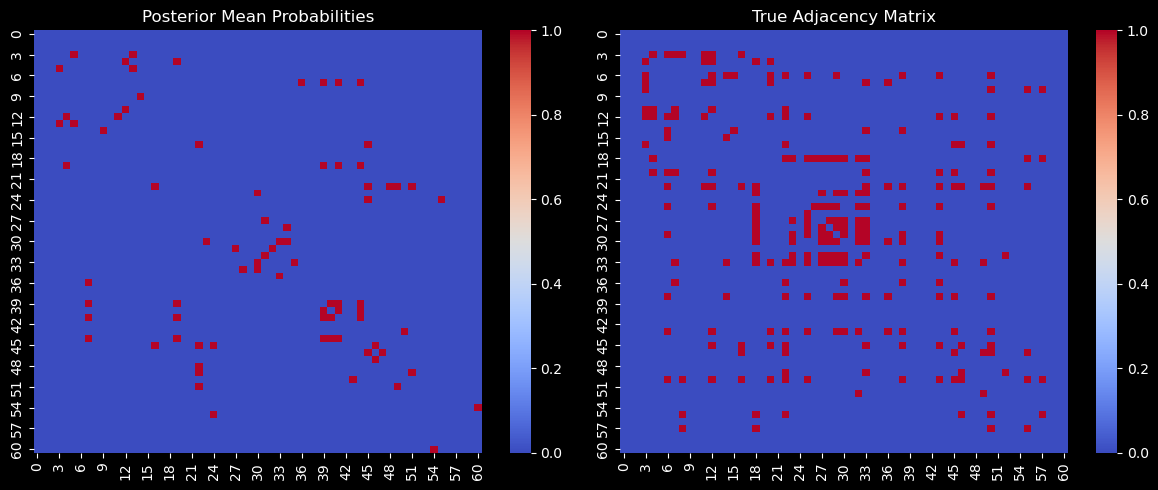

In [19]:
plot_heatmaps(triu_to_mat(agg_and), true_mat)

In [20]:
@jax.jit
def cut_post_log_density(triu_vals, post_probs):
    """
    Compute the log density of the posterior probabilities for the observed edges.
    
    Arguments:
    - triu_vals: n_layers x n choose 2 array of edge values.
    - post_probs: n choose 2 array of posterior probabilities.
    
    Returns:
    - log likelihood of the observed edges under the posterior probabilities.
    """
    return jnp.sum(triu_vals * jnp.log(post_probs) + (1 - triu_vals) * jnp.log1p(post_probs))

vmap_post_density = jax.vmap(cut_post_log_density, in_axes=(0, None))

def max_post_net(triu_samps, probs):
    """
    Find the network with the highest posterior density.
    
    Arguments:
    - triu_samps: n_samples x n choose 2 array of posterior samples.
    - probs: n choose 2 array of posterior probabilities.
    
    Returns:
    - n choose 2 array of the network with the highest posterior density.
    """
    log_densities = vmap_post_density(triu_samps, probs)
    max_idx = jnp.argmax(log_densities)
    return triu_samps[max_idx]




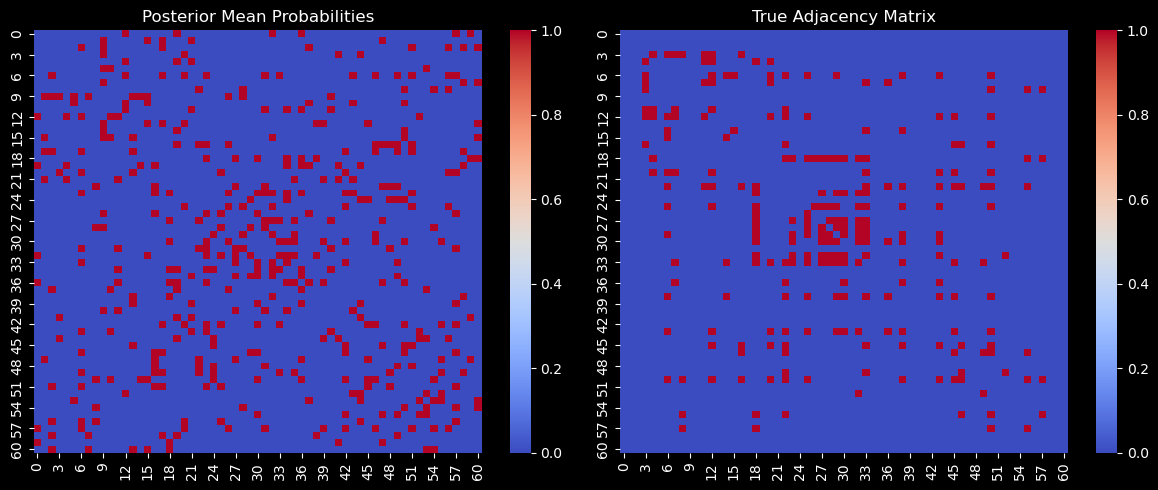

In [21]:
max_post_triu = max_post_net(post_triu, post_probs)

plot_heatmaps(triu_to_mat(max_post_triu), true_mat)

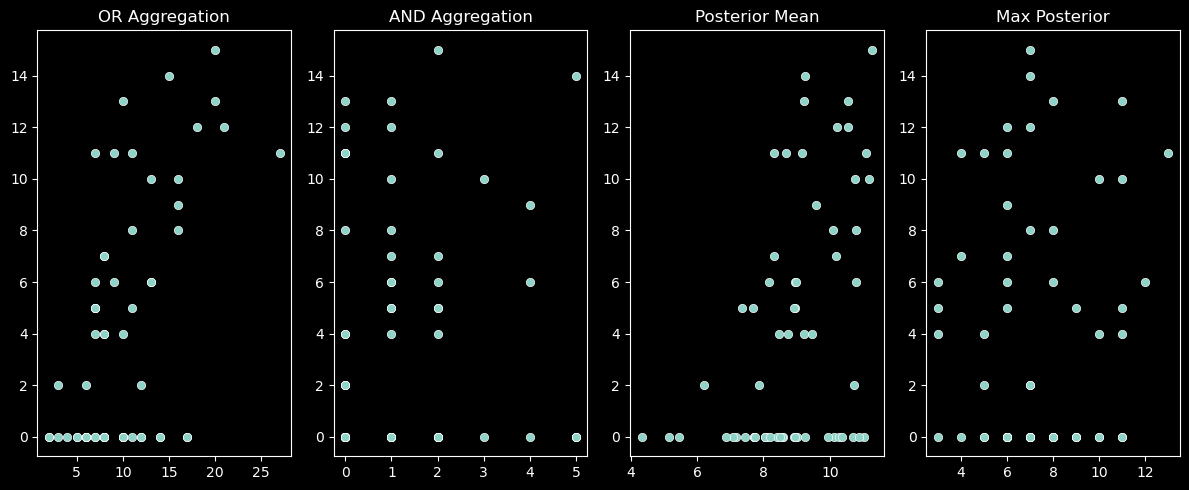

or~true cor 0.5666671
and~true cor 0.04013872
post~true cor 0.43994018
max_post~true cor 0.07717976
or~true rmse 7.5270004
and~true rmse 5.5927353
post~true rmse 6.4362974
max_post~true rmse 5.989061


In [22]:
agg_or_degs = compute_deg(agg_or)
agg_and_degs = compute_deg(agg_and)
max_post_deg = compute_deg(max_post_triu)

fig, axs = plt.subplots(1, 4, figsize=(12, 5))

sns.scatterplot(x=agg_or_degs, y=true_deg, ax=axs[0])
axs[0].set_title("OR Aggregation")

sns.scatterplot(x=agg_and_degs, y=true_deg, ax=axs[1])
axs[1].set_title("AND Aggregation")

sns.scatterplot(x=post_degs.mean(axis=0), y=true_deg, ax=axs[2])
axs[2].set_title("Posterior Mean")

sns.scatterplot(x=max_post_deg, y=true_deg, ax=axs[3])
axs[3].set_title("Max Posterior")

plt.tight_layout()
plt.show()

print("or~true cor", jnp.corrcoef(agg_or_degs, true_deg)[0,1])
print("and~true cor", jnp.corrcoef(agg_and_degs, true_deg)[0,1])
print("post~true cor", jnp.corrcoef(post_degs.mean(axis=0), true_deg)[0,1])
print("max_post~true cor", jnp.corrcoef(max_post_deg, true_deg)[0,1])

print("or~true rmse", jnp.sqrt(jnp.mean((agg_or_degs - true_deg)**2)))
print("and~true rmse", jnp.sqrt(jnp.mean((agg_and_degs - true_deg)**2)))
print("post~true rmse", jnp.sqrt(jnp.mean((post_degs.mean(axis=0) - true_deg)**2)))
print("max_post~true rmse", jnp.sqrt(jnp.mean((max_post_deg - true_deg)**2)))

In [23]:
# generate synthetic data
import Simulations.data_gen as dg
import src.utils as utils

@jax.jit
def degree_centrality(adj_matrix):
    """
    Compute normalized degree centrality

    Parameters:
    adj_matrix (jnp.ndarray): Square adjacency matrix (n x n)

    Returns:
    jnp.ndarray: Vector of normalized degree centralities
    """
    # Compute degrees (sum of rows for undirected graph)
    degrees = jnp.sum(adj_matrix, axis=1)

    # Normalize by maximum possible degree (n-1)
    n = adj_matrix.shape[0]
    # return degrees / (n - 1)
    return degrees / (n - 1)

@jax.jit
def compute_exposures(triu_star, Z):
    mat_star = triu_to_mat(triu_star)
    deg_cen = degree_centrality(mat_star)
    return utils.weighted_exposures(Z, deg_cen, mat_star)

vmap_compute_exposures = jax.vmap(compute_exposures, in_axes=(0, None))

def CAR_cov(triu_vals, sig_inv, rho, n):
    # Cov(Y) = \Sigma = sig_inv * (D - rho*A)^-1
    # So precision = \Sigma^{-1} = (1/sig_inv) * (D - rho*A)
    adj_mat = triu_to_mat(triu_vals)
    adj_mat += jnp.eye(n)  # Add self-loops
    degs_diag = jnp.sum(adj_mat, axis=1) * jnp.eye(n) 
    # Compute precision matrix Sigma^{-1}
    precis_ = sig_inv * (degs_diag - rho * adj_mat) 
    # Return Sigma
    return jnp.linalg.inv(precis_)


def generate_data(key, n, triu_star, eta, rho, sig_inv):
    z_key, y_key = random.split(key)
    Z = dg.generate_treatments(rng=z_key, n=n)
    expos = compute_exposures(triu_star, Z)
    df_nodes = jnp.transpose(jnp.stack([jnp.ones(n), Z, expos]))
    mean_y = df_nodes @ eta
    y_cov = CAR_cov(triu_star, sig_inv, rho, n)
    # y_cov = random.normal(y_key, shape=(n,))*sig_inv 
    print("y_cov is positive definite?", jnp.all(jnp.linalg.eigvals(y_cov) > 0))

    y = random.multivariate_normal(y_key, mean_y, y_cov)
    # y = mean_y + y_cov

    return {
        "Z": Z,
        "true_exposures": expos,
        "Y": y,
    }

In [24]:

ETA = jnp.array([-1, 3, 3])
SIG_INV = 1.0
RHO = 0.5

rng_key, _ = random.split(rng_key)
true_data = generate_data(key=rng_key,
                        n=num_nodes,
                        triu_star=latent_layer_triu,
                        eta=ETA,
                        rho=RHO,
                        sig_inv=SIG_INV)

print(true_data["Y"].shape)

y_cov is positive definite? True
(61,)


(array([34.,  4.,  5.,  4.,  3.,  2.,  4.,  2.,  1.,  2.]),
 array([0.        , 0.1       , 0.2       , 0.30000001, 0.40000001,
        0.5       , 0.60000002, 0.69999999, 0.80000001, 0.89999998,
        1.        ]),
 <BarContainer object of 10 artists>)

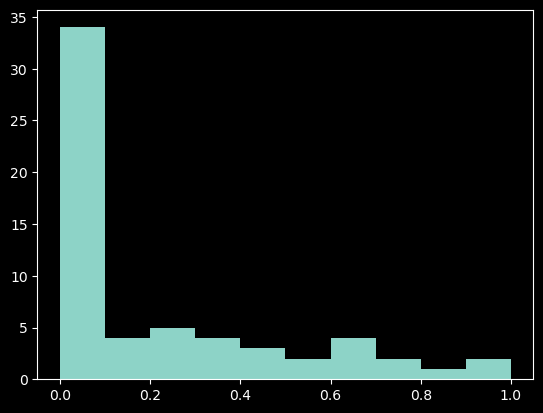

In [25]:
plt.hist(true_data["true_exposures"], bins=10)

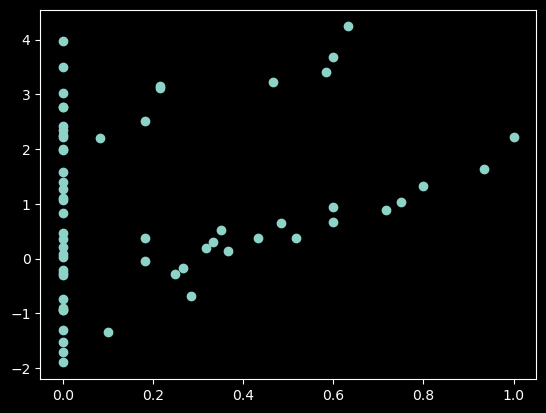

In [26]:
plt.scatter(true_data["true_exposures"], true_data["Y"])

In [27]:
def outcome_model(Z, exposures, Y):
    n = Z.shape[0]
    with numpyro.plate("eta_plate", 3):
        eta = numpyro.sample("eta", dist.Normal(0.0, 3.0))

    sig_inv = numpyro.sample("sig_inv", dist.Gamma(2,2))
    mean_y = jnp.transpose(jnp.stack([jnp.ones(n), Z, exposures])) @ eta

    numpyro.sample("Y", dist.Normal(mean_y, sig_inv), obs=Y)

In [28]:
import src.Models as models

# run plugin model with true data

obs_df_node = jnp.transpose(jnp.stack([jnp.ones(num_nodes), true_data["Z"], true_data["true_exposures"]]))
true_adj_mat = triu_to_mat(latent_layer_triu) + jnp.eye(num_nodes)

rng_key, _ = random.split(rng_key)
# plugin_kernel = NUTS(outcome_model)
plugin_kernel = NUTS(models.plugin_outcome_model)
plugin_mcmc = MCMC(plugin_kernel, num_warmup=2000, num_samples=2500, num_chains=4)

plugin_mcmc.run(rng_key, 
                # Z=true_data["Z"],
                # exposures=true_data["true_exposures"],
                df_nodes=obs_df_node,
                adj_mat=true_adj_mat,
                Y=true_data["Y"])

plugin_mcmc.print_summary()

plugin_samples = plugin_mcmc.get_samples()
print(plugin_samples.keys())


  0%|          | 0/4500 [00:00<?, ?it/s]

  0%|          | 0/4500 [00:00<?, ?it/s]

  0%|          | 0/4500 [00:00<?, ?it/s]

  0%|          | 0/4500 [00:00<?, ?it/s]


                mean       std    median      5.0%     95.0%     n_eff     r_hat
    eta[0]     -0.80      0.13     -0.80     -1.01     -0.60   4535.68      1.00
    eta[1]      2.89      0.12      2.89      2.69      3.09   5466.81      1.00
    eta[2]      2.74      0.20      2.74      2.42      3.08   4828.19      1.00
       rho      0.44      0.15      0.45      0.20      0.70   5243.85      1.00
   sig_inv      1.36      0.32      1.33      0.87      1.88   5698.54      1.00

Number of divergences: 0
dict_keys(['eta', 'rho', 'sig_inv'])


In [29]:
rng_key, _ = random.split(rng_key)
new_z = dg.generate_treatments(rng=rng_key, n=num_nodes, pz=0.7)
new_z2 = dg.generate_treatments(rng=rng_key, n=num_nodes, pz=0.3)
new_expos = compute_exposures(latent_layer_triu, new_z)
new_expos2 = compute_exposures(latent_layer_triu, new_z2)
new_mean = jnp.transpose(jnp.stack([jnp.ones(num_nodes), new_z, new_expos])) @ ETA
new_mean2 = jnp.transpose(jnp.stack([jnp.ones(num_nodes), new_z2, new_expos2])) @ ETA
new_estimand = new_mean - new_mean2
print(new_estimand.mean(), new_estimand.std(), new_estimand.min(), new_estimand.max())

1.6303277 1.4486365 0.0 3.9500003


In [30]:
from numpyro.infer import Predictive

new_df = jnp.transpose(jnp.stack([jnp.ones(num_nodes), new_z, new_expos]))
new_df2 = jnp.transpose(jnp.stack([jnp.ones(num_nodes), new_z2, new_expos2]))

# plugin_predictive = Predictive(outcome_model, plugin_samples, return_sites=["Y"])
plugin_predictive = Predictive(models.plugin_outcome_model, plugin_samples, return_sites=["Y"])
rng_key, _ = random.split(rng_key)
estimate_1 = plugin_predictive(rng_key, 
                            # Z=new_z,
                            # exposures=new_expos,
                            df_nodes=new_df,
                            adj_mat = true_adj_mat,
                            Y=None)["Y"]

rng_key, _ = random.split(rng_key)
estimate_2 = plugin_predictive(rng_key, 
                            # Z=new_z2,
                            # exposures=new_expos2,
                            df_nodes=new_df2,
                            adj_mat = true_adj_mat,
                            Y=None)["Y"]

plugin_estimates = estimate_1 - estimate_2
print(plugin_estimates.shape, plugin_estimates.mean())



(10000, 61) 1.5475068


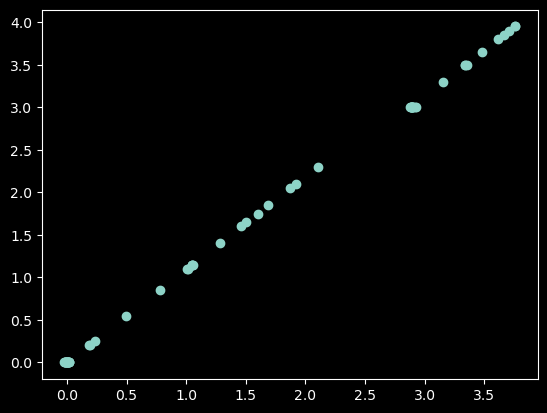

In [31]:
plt.scatter(plugin_estimates.mean(axis=0), new_estimand)

In [32]:
# run with posterior exposures

# get posterior exposures

post_expos = vmap_compute_exposures(post_triu, true_data["Z"]).mean(axis=0)
post_df = jnp.transpose(jnp.stack([jnp.ones(num_nodes), true_data["Z"], post_expos]))

post_adj_mat = triu_to_mat(max_post_triu) + jnp.eye(num_nodes)

# run mcmc
rng_key, _ = random.split(rng_key)
post_mcmc = MCMC(plugin_kernel, num_warmup=2000, num_samples=2500, num_chains=4)
post_mcmc.run(rng_key, 
                # Z=true_data["Z"],
                # exposures=post_expos,
                df_nodes = post_df,
                adj_mat=post_adj_mat,
                Y=true_data["Y"])

post_mcmc.print_summary()

post_samples = post_mcmc.get_samples()


  0%|          | 0/4500 [00:00<?, ?it/s]

  0%|          | 0/4500 [00:00<?, ?it/s]

  0%|          | 0/4500 [00:00<?, ?it/s]

  0%|          | 0/4500 [00:00<?, ?it/s]


                mean       std    median      5.0%     95.0%     n_eff     r_hat
    eta[0]     -1.20      0.65     -1.21     -2.26     -0.14   3818.20      1.00
    eta[1]      2.29      0.27      2.29      1.86      2.74   6613.44      1.00
    eta[2]      1.86      0.90      1.88      0.31      3.28   3878.04      1.00
       rho      0.48      0.21      0.48      0.14      0.82   6437.67      1.00
   sig_inv      0.12      0.02      0.12      0.09      0.16   7139.27      1.00

Number of divergences: 0


In [33]:
# post_estimand with true model

post_expos_new_z = vmap_compute_exposures(post_triu, new_z).mean(axis=0)
post_expos_new_z2 = vmap_compute_exposures(post_triu, new_z2).mean(axis=0)

new_df_post = jnp.transpose(jnp.stack([jnp.ones(num_nodes), new_z, post_expos_new_z]))
new_df_post2 = jnp.transpose(jnp.stack([jnp.ones(num_nodes), new_z2, post_expos_new_z2]))


# post_predictive = Predictive(outcome_model, post_samples, return_sites=["Y"])
post_predictive = Predictive(models.plugin_outcome_model, post_samples, return_sites=["Y"])
rng_key, _ = random.split(rng_key)
post_mean_1 = post_predictive(rng_key, 
                                # Z=new_z,
                                # exposures=post_expos_new_z,
                                df_nodes = new_df_post,
                                adj_mat = post_adj_mat,
                                Y=None)["Y"]

rng_key, _ = random.split(rng_key)
post_mean_2 = post_predictive(rng_key,
                                # Z=new_z2,
                                # exposures=post_expos_new_z2,
                                df_nodes = new_df_post2,
                                adj_mat = post_adj_mat,
                                Y=None)["Y"]

post_estimates = post_mean_1 - post_mean_2
# post_estimates = post_samples_predictive["Y"]

print(post_estimates.shape, post_estimates.mean())

(10000, 61) 1.9232627


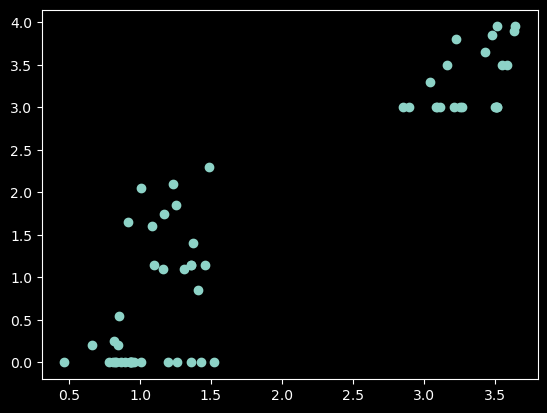

In [34]:
plt.scatter(post_estimates.mean(axis=0), new_estimand)

In [35]:
utils.compute_error_stats(post_estimates=plugin_estimates,
                          true_estimand=new_estimand,
                          wasserstein_dist=1.0)


{'mean': Array(1.5475099, dtype=float32),
 'median': Array(1.51861, dtype=float32),
 'true': Array(1.63033, dtype=float32),
 'bias': Array(-0.08282, dtype=float32),
 'std': Array(0.173, dtype=float32),
 'RMSE': Array(0.19181, dtype=float32),
 'RMSE_rel': Array(0.11764999, dtype=float32),
 'MAE': Array(0.08639, dtype=float32),
 'MAPE': Array(3734.1672, dtype=float32),
 'q025': Array(1.2153591, dtype=float32),
 'q975': Array(1.8916421, dtype=float32),
 'covering': Array(True, dtype=bool),
 'mean_ind_cover': Array(1., dtype=float32),
 'w_dist': 1.0}

In [36]:
utils.compute_error_stats(post_estimates=post_estimates,
                          true_estimand=new_estimand,
                          wasserstein_dist=1.0)


{'mean': Array(1.92326, dtype=float32),
 'median': Array(1.8981199, dtype=float32),
 'true': Array(1.63033, dtype=float32),
 'bias': Array(0.29293, dtype=float32),
 'std': Array(0.60446, dtype=float32),
 'RMSE': Array(0.6717, dtype=float32),
 'RMSE_rel': Array(0.412, dtype=float32),
 'MAE': Array(0.56303996, dtype=float32),
 'MAPE': Array(309387.1, dtype=float32),
 'q025': Array(0.71255183, dtype=float32),
 'q975': Array(3.1065369, dtype=float32),
 'covering': Array(True, dtype=bool),
 'mean_ind_cover': Array(1., dtype=float32),
 'w_dist': 1.0}

In [37]:
# now with agg_or network

agg_or_expos = compute_exposures(agg_or, true_data["Z"])

agg_df_nodes = jnp.transpose(jnp.stack([jnp.ones(num_nodes), true_data["Z"], agg_or_expos]))
agg_adj_mat = triu_to_mat(agg_or) + jnp.eye(num_nodes)

# run mcmc
rng_key, _ = random.split(rng_key)
agg_or_mcmc = MCMC(plugin_kernel, num_warmup=2000, num_samples=2500, num_chains=4)
agg_or_mcmc.run(rng_key, 
                # Z=true_data["Z"],
                # exposures=agg_or_expos,
                df_nodes = agg_df_nodes,
                adj_mat=agg_adj_mat,
                Y=true_data["Y"])

agg_or_mcmc.print_summary()

agg_or_samples = agg_or_mcmc.get_samples()

  0%|          | 0/4500 [00:00<?, ?it/s]

  0%|          | 0/4500 [00:00<?, ?it/s]

  0%|          | 0/4500 [00:00<?, ?it/s]

  0%|          | 0/4500 [00:00<?, ?it/s]


                mean       std    median      5.0%     95.0%     n_eff     r_hat
    eta[0]     -0.28      0.38     -0.28     -0.91      0.34   5391.24      1.00
    eta[1]      2.20      0.27      2.19      1.76      2.65   7247.38      1.00
    eta[2]      0.47      0.27      0.47      0.01      0.89   5844.34      1.00
       rho      0.49      0.21      0.49      0.16      0.85   6735.86      1.00
   sig_inv      0.09      0.02      0.09      0.06      0.12   7421.62      1.00

Number of divergences: 0


In [38]:
# predictive estimate

agg_or_post_expos = compute_exposures(agg_or, new_z)
agg_or_post_expos2 = compute_exposures(agg_or, new_z2)

agg_or_post_df = jnp.transpose(jnp.stack([jnp.ones(num_nodes), new_z, agg_or_post_expos]))
agg_or_post_df2 = jnp.transpose(jnp.stack([jnp.ones(num_nodes), new_z2, agg_or_post_expos2]))

# agg_or_predictive = Predictive(outcome_model, agg_or_samples, return_sites=["Y"])
agg_or_predictive = Predictive(models.plugin_outcome_model, agg_or_samples, return_sites=["Y"])
rng_key, _ = random.split(rng_key)
agg_or_mean1 = agg_or_predictive(rng_key, 
                                # Z=new_z,
                                # exposures=agg_or_post_expos,
                                df_nodes = agg_or_post_df,
                                adj_mat = agg_adj_mat,
                                Y=None)["Y"]

rng_key, _ = random.split(rng_key)
agg_or_mean2 = agg_or_predictive(rng_key,
                                # Z=new_z2,
                                # exposures=agg_or_post_expos2,
                                df_nodes = agg_or_post_df2,
                                adj_mat = agg_adj_mat,
                                Y=None)["Y"]

# agg_or_estimates = agg_or_samples_predictive["Y"]
agg_or_estimates = agg_or_mean1 - agg_or_mean2
print(agg_or_estimates.shape, agg_or_estimates.mean())

utils.compute_error_stats(post_estimates=agg_or_estimates,
                            true_estimand=new_estimand,
                            wasserstein_dist=1.0)

(10000, 61) 1.1667118


{'mean': Array(1.16671, dtype=float32),
 'median': Array(1.1412799, dtype=float32),
 'true': Array(1.63033, dtype=float32),
 'bias': Array(-0.46361998, dtype=float32),
 'std': Array(0.39927, dtype=float32),
 'RMSE': Array(0.61184996, dtype=float32),
 'RMSE_rel': Array(0.37528998, dtype=float32),
 'MAE': Array(0.6333, dtype=float32),
 'MAPE': Array(84465.37, dtype=float32),
 'q025': Array(0.3525667, dtype=float32),
 'q975': Array(1.9173334, dtype=float32),
 'covering': Array(True, dtype=bool),
 'mean_ind_cover': Array(1., dtype=float32),
 'w_dist': 1.0}

In [39]:
# agg_and 

agg_and_expos = compute_exposures(agg_and, true_data["Z"])

agg_and_df = jnp.transpose(jnp.stack([jnp.ones(num_nodes), true_data["Z"], agg_and_expos]))

agg_and_adj_mat = triu_to_mat(agg_and) + jnp.eye(num_nodes)

# run mcmc
rng_key, _ = random.split(rng_key)
agg_and_mcmc = MCMC(plugin_kernel, num_warmup=2000, num_samples=2500, num_chains=4)
agg_and_mcmc.run(rng_key, 
                # Z=true_data["Z"],
                # exposures=agg_and_expos,
                df_nodes = agg_and_df,
                adj_mat=agg_and_adj_mat,
                Y=true_data["Y"])

agg_and_mcmc.print_summary()

agg_and_samples = agg_and_mcmc.get_samples()


  0%|          | 0/4500 [00:00<?, ?it/s]

  0%|          | 0/4500 [00:00<?, ?it/s]

  0%|          | 0/4500 [00:00<?, ?it/s]

  0%|          | 0/4500 [00:00<?, ?it/s]


                mean       std    median      5.0%     95.0%     n_eff     r_hat
    eta[0]      0.30      0.21      0.30     -0.04      0.65   7032.41      1.00
    eta[1]      1.82      0.28      1.81      1.35      2.28   7452.12      1.00
    eta[2]      0.06      1.76      0.03     -2.75      3.01   8938.89      1.00
       rho      0.21      0.12      0.20      0.02      0.38   8763.17      1.00
   sig_inv      0.43      0.08      0.42      0.30      0.56   8198.03      1.00

Number of divergences: 0


In [40]:
# predictive estimate

agg_and_post_expos = compute_exposures(agg_and, new_z)
agg_and_post_expos2 = compute_exposures(agg_and, new_z2)

agg_and_post_df = jnp.transpose(jnp.stack([jnp.ones(num_nodes), new_z, agg_and_post_expos]))
agg_and_post_df2 = jnp.transpose(jnp.stack([jnp.ones(num_nodes), new_z2, agg_and_post_expos2]))

# agg_and_predictive = Predictive(outcome_model, agg_and_samples, return_sites=["Y"])
agg_and_predictive = Predictive(models.plugin_outcome_model, agg_and_samples, return_sites=["Y"])

rng_key, _ = random.split(rng_key)
agg_and_mean1 = agg_and_predictive(rng_key, 
                                    # Z=new_z,
                                    # exposures=agg_and_post_expos,
                                    df_nodes = agg_and_post_df,
                                    adj_mat = agg_and_adj_mat,
                                    Y=None)["Y"]

rng_key, _ = random.split(rng_key)
agg_and_mean2 = agg_and_predictive(rng_key,
                                    # Z=new_z2,
                                    # exposures=agg_and_post_expos2,
                                    df_nodes = agg_and_post_df2,
                                    adj_mat = agg_and_adj_mat,
                                    Y=None)["Y"]

agg_and_estimates = agg_and_mean1 - agg_and_mean2
# agg_and_estimates = agg_and_samples_predictive["Y"]
print(agg_and_estimates.shape, agg_and_estimates.mean())

utils.compute_error_stats(post_estimates=agg_and_estimates,
                            true_estimand=new_estimand,
                            wasserstein_dist=1.0)


(10000, 61) 0.6890204


{'mean': Array(0.68902, dtype=float32),
 'median': Array(0.60529, dtype=float32),
 'true': Array(1.63033, dtype=float32),
 'bias': Array(-0.94131, dtype=float32),
 'std': Array(0.27289, dtype=float32),
 'RMSE': Array(0.98006, dtype=float32),
 'RMSE_rel': Array(0.60115, dtype=float32),
 'MAE': Array(0.94470996, dtype=float32),
 'MAPE': Array(3635.374, dtype=float32),
 'q025': Array(0.15541287, dtype=float32),
 'q975': Array(1.2224201, dtype=float32),
 'covering': Array(False, dtype=bool),
 'mean_ind_cover': Array(0.98361, dtype=float32),
 'w_dist': 1.0}